In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [12]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [13]:
# Convert 'country', 'account_currency', 'Trading_Method' and 'active' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')
modelling_df['active'] = modelling_df['active'].astype('category')
modelling_df['has_credit'] = modelling_df['has_credit'].astype('category')

Split the Dataset

In [14]:
# Sort the DataFrame by 'longevity'
modelling_df = modelling_df.sort_values(by=['longevity'])

# Get the split index for 90%
split_index = int(modelling_df.shape[0] * 0.9)

# Split the dataset
top_10_percent = modelling_df.iloc[split_index:]
bottom_90_percent = modelling_df.iloc[0:split_index]

In [15]:
bottom_90_percent['longevity'].describe()

count    5122.000000
mean       25.892425
std        32.584176
min         0.000000
25%         1.000000
50%        11.000000
75%        41.000000
max       128.000000
Name: longevity, dtype: float64

In [16]:
top_10_percent['longevity'].describe()

count    570.000000
mean     215.957895
std       79.588716
min      129.000000
25%      154.000000
50%      189.500000
75%      253.000000
max      415.000000
Name: longevity, dtype: float64

# Functions and Defintions

In [17]:
# Define regression models
regression_models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(criterion='squared_error'),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', max_depth='5', eta='0.05', eval_metric='rmse', alpha='0.1', reg_lambda='1'),  
    # "Neural Network Regressor": MLPRegressor(max_iter=10000),
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(),
    # "Lasso Regression": Lasso(),
    # "KNeighbors Regressor": KNeighborsRegressor(),
    # "Support Vector Regressor": SVR()
}

In [18]:
def DisplayFeatureImportanceOrCoefficients(model, X_preprocessed_df):
    if hasattr(model, 'feature_importances_'):
        feature_importances = list(zip(X_preprocessed_df.columns, model.feature_importances_))
        headers = ["Feature", "Importance"]
        print("Feature Importances:")
        print("Original:")
        print(tabulate(feature_importances, headers=headers, tablefmt="rounded_outline"))
        print("\nSorted:")
        feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)
        print(tabulate(feature_importances_sorted, headers=headers, tablefmt="rounded_outline"))
    elif hasattr(model, 'coef_'):
        feature_coefficients = list(zip(X_preprocessed_df.columns, model.coef_))
        headers = ["Feature", "Coefficient"]
        print("Feature Coefficients:")
        print("Original:")
        print(tabulate(feature_coefficients, headers=headers, tablefmt="rounded_outline"))
        print("\nSorted (by absolute value):")
        feature_coefficients_sorted = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)
        print(tabulate(feature_coefficients_sorted, headers=headers, tablefmt="rounded_outline"))
    else:
        print("Feature importance or coefficients not available for this model.")


In [19]:
def DisplayMetrics(model, X, y, metricType):
    y_pred = model.predict(X)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    headers = [metricType, "Value"]
    data = [
        ["Mean Absolute Error (MAE)", f"{mae:.4f}"],
        ["Mean Squared Error (MSE)", f"{mse:.4f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.4f}"],
        ["R-squared (R2)", f"{r2:.4f}"]
    ]
    
    print(tabulate(data, headers=headers, tablefmt="rounded_outline"))
    print()
    
    return y_pred

In [20]:
def PerformPlot(name, y_test, y_test_pred, limits):
    # Plotting true vs predicted values for test set
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(y_test, y_test_pred, color='blue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel('True Values', fontsize=18)
    ax.set_ylabel('Predicted Values', fontsize=18)
    ax.set_title('True vs Predicted Values (Test Set)', fontsize=14)
    plt.suptitle(name, fontsize=24)
    plt.show()

# Bottom 90 Model

In [21]:
bottom_90_percent

,login,country,account_currency,Trading_Frequency,Total_Trades,Buy_Percentage,Average_Volume,Average_Volume_USD,Average_DPM,Unique_Symbols_Traded,...,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,has_credit,active,net_deposit_frequency_ratio,Trading_Method,longevity,longevity_bin
4691,7058367,Vietnam,USD,2.000000,2,0.000000,0.980000,4.588108e+05,-201.951050,1.000000,...,0.00,0.000000,-124.620000,2.623579,0.0,False,0.032609,Client,0,0
5254,7061207,Vietnam,USD,1.000000,1,0.000000,0.800000,3.239480e+05,-787.780755,1.000000,...,0.00,0.000000,-255.200000,3.448649,0.0,False,0.042254,Client,0,0
5255,7061209,Vietnam,USD,1.000000,1,100.000000,0.010000,2.214920e+03,18.059343,1.000000,...,-0.07,0.000000,0.040000,0.013514,0.0,False,0.027778,Client,0,0
872,811572,United Kingdom,GBP,1.000000,1,0.000000,0.010000,2.493380e+03,-185.019291,1.000000,...,0.00,0.000000,-0.461323,0.653595,0.0,False,0.003279,Client,0,0
2039,817839,Austria,EUR,4.000000,4,25.000000,0.127500,4.110799e+04,11.463233,2.000000,...,0.00,0.000000,-0.275012,0.006124,0.0,False,0.009662,Client,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,813559,New Zealand,NZD,3.257812,417,56.594724,0.067314,2.581894e+04,12.843595,1.600000,...,0.00,-0.031829,-2.133775,6.181818,0.0,False,0.026119,Mobile,128,2
1440,815016,Canada,CAD,38.914062,4981,17.145152,0.059428,2.298827e+04,-37.113021,1.000000,...,0.00,-0.129952,-0.624154,14.549685,0.0,False,0.094828,Expert,128,2
99,805330,Australia,AUD,6.000000,768,50.911458,0.267526,4.553493e+07,-3.906625,17.666667,...,0.00,-0.005867,-1.873394,19.093199,0.0,False,0.007614,Client,128,2
1595,816065,Papua New Guinea,USD,6.742188,863,64.078795,0.090892,9.061871e+06,-107.953292,7.600000,...,0.00,-0.013824,-1.722422,7.218085,0.0,False,0.113744,Mobile,128,2


In [22]:
# Remove specified columns and set 'longevity' as the target variable
X = bottom_90_percent.drop(columns=['login', 'Total_Trades', 'active', 'Average_Volume', 'longevity', 'longevity_bin'])
y = bottom_90_percent['longevity']

In [23]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method', 'has_credit']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades', 'net_deposit_frequency_ratio']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 3584
Test Set Size: 769
Validation Set Size: 769


Decision Tree Regressor - Bottom 90
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.191327   │
│ Average_Volume_USD          │   0.0317912  │
│ Average_DPM                 │   0.0641261  │
│ Unique_Symbols_Traded       │   0.0293974  │
│ Peak_Trading_Times          │   0.0179671  │
│ Profit_Loss_Variability     │   0.0604675  │
│ Average_Trade_Duration      │   0.0521369  │
│ Average_Commission          │   0.00247062 │
│ Average_Swaps               │   0.0908771  │
│ Average_Profit              │   0.0499008  │
│ average_net_deposit         │   0.0676868  │
│ Buy_Percentage              │   0.0368773  │
│ TP/SL Hit Ratio             │   0.152064   │
│ Reward_Risk_Ratio           │   0.0109564  │
│ Ratio_Profitable_Trades     │   0.0523141  │
│ net_deposit_frequency_ratio │   0.0421176  │
│ country                     │   0.0335

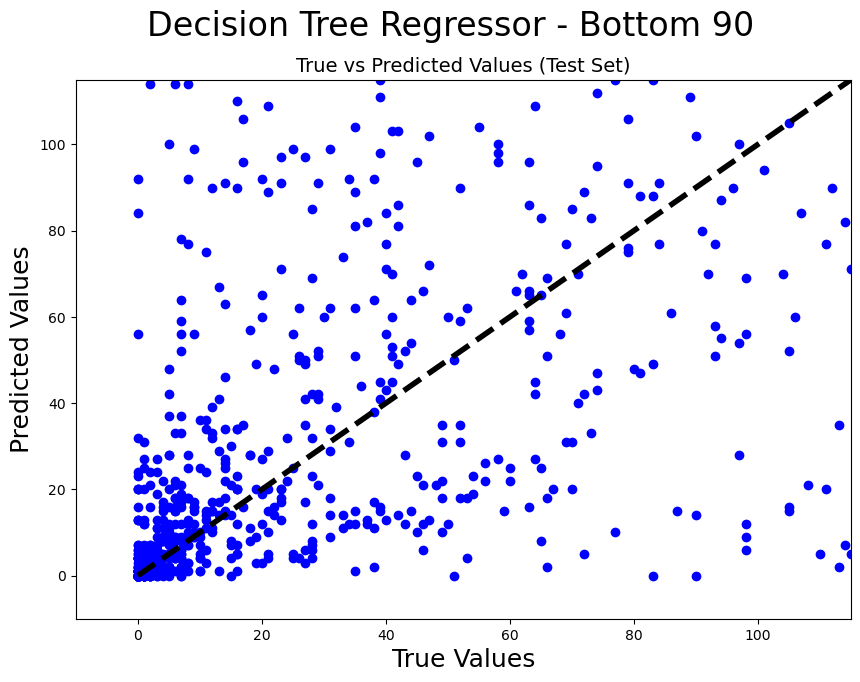

Random Forest Regressor - Bottom 90
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.186725   │
│ Average_Volume_USD          │   0.0328911  │
│ Average_DPM                 │   0.0525582  │
│ Unique_Symbols_Traded       │   0.0285402  │
│ Peak_Trading_Times          │   0.0207668  │
│ Profit_Loss_Variability     │   0.0476565  │
│ Average_Trade_Duration      │   0.0420115  │
│ Average_Commission          │   0.00918449 │
│ Average_Swaps               │   0.0757775  │
│ Average_Profit              │   0.0479638  │
│ average_net_deposit         │   0.0693352  │
│ Buy_Percentage              │   0.0384788  │
│ TP/SL Hit Ratio             │   0.157918   │
│ Reward_Risk_Ratio           │   0.0117754  │
│ Ratio_Profitable_Trades     │   0.0676765  │
│ net_deposit_frequency_ratio │   0.0479944  │
│ country                     │   0.0360

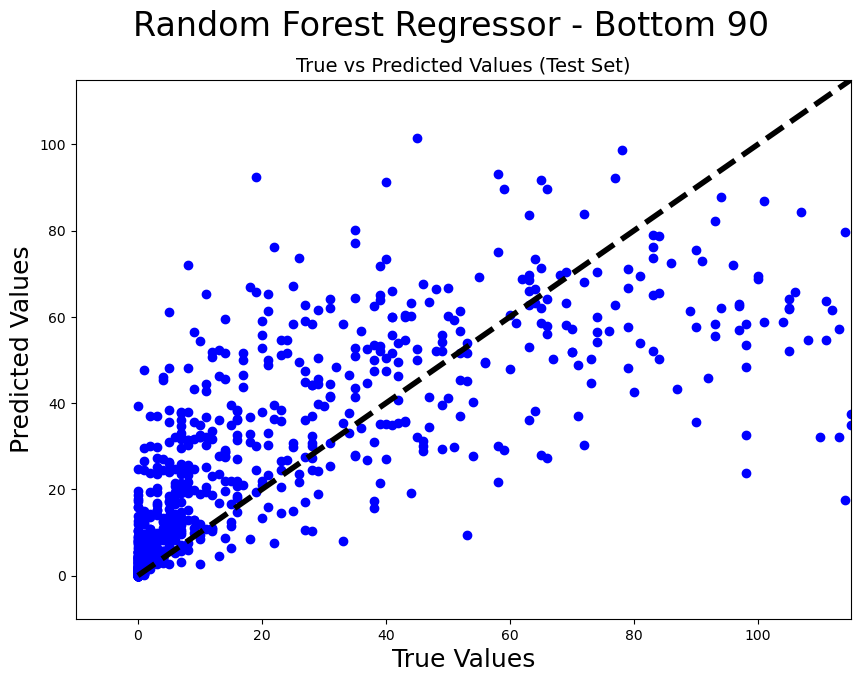

XGBoost Regressor - Bottom 90
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │    0.0705397 │
│ Average_Volume_USD          │    0.0209346 │
│ Average_DPM                 │    0.0496698 │
│ Unique_Symbols_Traded       │    0.0228409 │
│ Peak_Trading_Times          │    0.0231574 │
│ Profit_Loss_Variability     │    0.0418685 │
│ Average_Trade_Duration      │    0.027824  │
│ Average_Commission          │    0.0142231 │
│ Average_Swaps               │    0.0788747 │
│ Average_Profit              │    0.0523329 │
│ average_net_deposit         │    0.0442499 │
│ Buy_Percentage              │    0.064017  │
│ TP/SL Hit Ratio             │    0.228337  │
│ Reward_Risk_Ratio           │    0.0211816 │
│ Ratio_Profitable_Trades     │    0.0709618 │
│ net_deposit_frequency_ratio │    0.0268137 │
│ country                     │    0.0486316 │

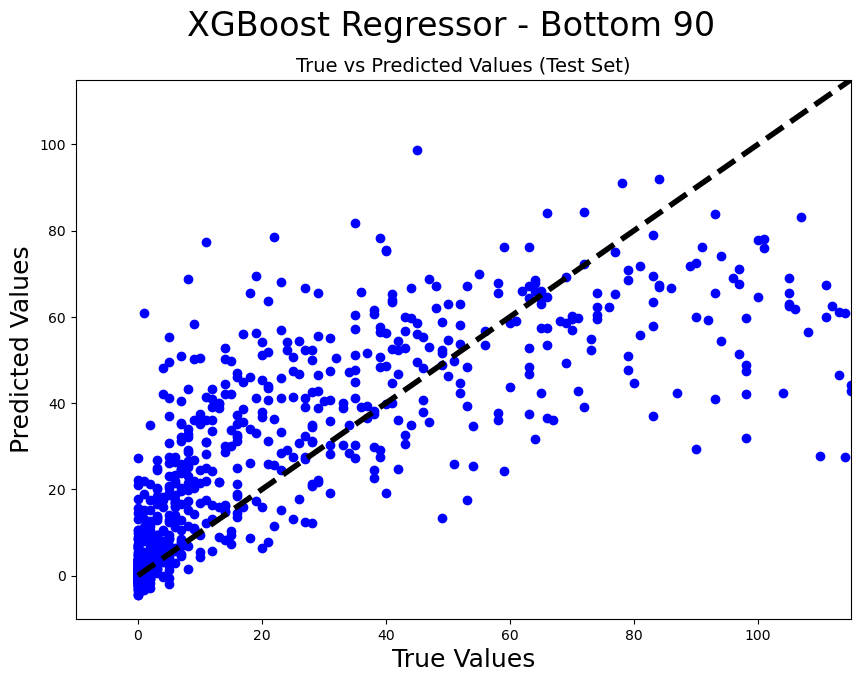

In [25]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name} - Bottom 90")
    # Train the model on the training set
    model.fit(X_train, y_train)

    DisplayFeatureImportanceOrCoefficients(model, X_preprocessed_df)

    # Evaluate Metrics on Model
    DisplayMetrics(model, X_val, y_val, "Validation")
    y_test_pred = DisplayMetrics(model, X_test, y_test, "Testing")

    PerformPlot(f"{name} - Bottom 90", y_test, y_test_pred, [-10, 115])

# Top 10 Model

In [26]:
top_10_percent

,login,country,account_currency,Trading_Frequency,Total_Trades,Buy_Percentage,Average_Volume,Average_Volume_USD,Average_DPM,Unique_Symbols_Traded,...,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,has_credit,active,net_deposit_frequency_ratio,Trading_Method,longevity,longevity_bin
1005,812364,United Kingdom,GBP,0.565891,73,46.575342,0.114932,4.375503e+04,-20.764279,2.600000,...,0.000000,0.077208,-12.062665,2.427611,0.0,False,0.020906,Mobile,129,2
1874,817256,Singapore,USD,32.472868,4189,55.526379,0.019752,5.941838e+03,-47.015182,1.000000,...,0.000000,-0.191024,1.294371,-16.682545,0.0,False,0.114865,Expert,129,2
2871,821725,Italy,EUR,6.542636,844,52.962085,0.367227,1.743090e+05,-44.818881,5.000000,...,0.000000,-0.009387,3.478264,-14.134094,0.0,False,0.380435,Mobile,129,2
1119,812928,India,USD,0.217054,28,60.714286,0.057857,1.508129e+07,218.198715,2.333333,...,0.000000,0.005000,3.474643,0.000000,1.0,False,0.007092,Mobile,129,2
911,811827,United Kingdom,GBP,0.372093,48,68.750000,0.055833,6.233289e+07,-333.958407,6.250000,...,0.000000,-0.302931,-3.794401,0.662252,0.0,False,0.003322,Mobile,129,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5653,88944559,Poland,EUR,5.916462,2408,45.265781,0.126773,3.553048e+07,1.968139,15.142857,...,-0.486098,-0.058576,0.107375,12.771084,0.0,True,0.002415,Expert,407,5
5657,88944610,Canada,USD,0.356265,145,47.586207,0.025448,1.832140e+07,-90.848951,2.642857,...,-0.116345,-0.521793,-2.254483,1.099469,0.0,True,0.007299,Expert,407,5
5663,88944676,South Africa,USD,3.100490,1265,32.569170,1.445549,7.830123e+07,-41.410931,6.166667,...,-0.004980,0.007257,-17.009423,0.000000,1.0,True,0.000000,Expert,408,5
5639,88944431,Romania,EUR,2.253623,933,53.590568,0.080182,1.258499e+07,-32.279963,1.230769,...,-0.053907,-0.358663,-1.062936,7.194245,0.0,True,0.004819,Expert,414,5


In [27]:
# Remove specified columns and set 'longevity' as the target variable
X = top_10_percent.drop(columns=['login', 'Total_Trades', 'active', 'Average_Volume', 'longevity', 'longevity_bin'])
y = top_10_percent['longevity']

In [28]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method', 'has_credit']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades', 'net_deposit_frequency_ratio']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [29]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 398
Test Set Size: 86
Validation Set Size: 86


Decision Tree Regressor - Top 10
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.0371638  │
│ Average_Volume_USD          │   0.0463155  │
│ Average_DPM                 │   0.018081   │
│ Unique_Symbols_Traded       │   0.0425211  │
│ Peak_Trading_Times          │   0.0243963  │
│ Profit_Loss_Variability     │   0.0319393  │
│ Average_Trade_Duration      │   0.0908511  │
│ Average_Commission          │   0.159199   │
│ Average_Swaps               │   0.0655714  │
│ Average_Profit              │   0.0248897  │
│ average_net_deposit         │   0.0367166  │
│ Buy_Percentage              │   0.0391133  │
│ TP/SL Hit Ratio             │   0.0898867  │
│ Reward_Risk_Ratio           │   0.0746225  │
│ Ratio_Profitable_Trades     │   0.0425214  │
│ net_deposit_frequency_ratio │   0.0893533  │
│ country                     │   0.0562119

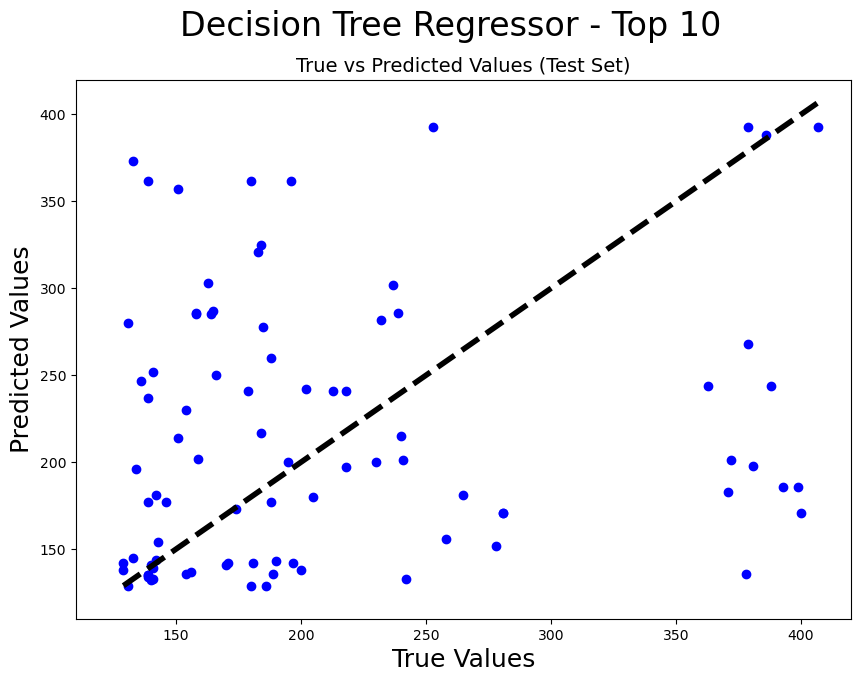

Random Forest Regressor - Top 10
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.0594272  │
│ Average_Volume_USD          │   0.0814204  │
│ Average_DPM                 │   0.051869   │
│ Unique_Symbols_Traded       │   0.05597    │
│ Peak_Trading_Times          │   0.0295171  │
│ Profit_Loss_Variability     │   0.0357312  │
│ Average_Trade_Duration      │   0.0753343  │
│ Average_Commission          │   0.0623325  │
│ Average_Swaps               │   0.0529063  │
│ Average_Profit              │   0.0443501  │
│ average_net_deposit         │   0.0474504  │
│ Buy_Percentage              │   0.0485443  │
│ TP/SL Hit Ratio             │   0.0852049  │
│ Reward_Risk_Ratio           │   0.0644709  │
│ Ratio_Profitable_Trades     │   0.044162   │
│ net_deposit_frequency_ratio │   0.0811309  │
│ country                     │   0.035554 

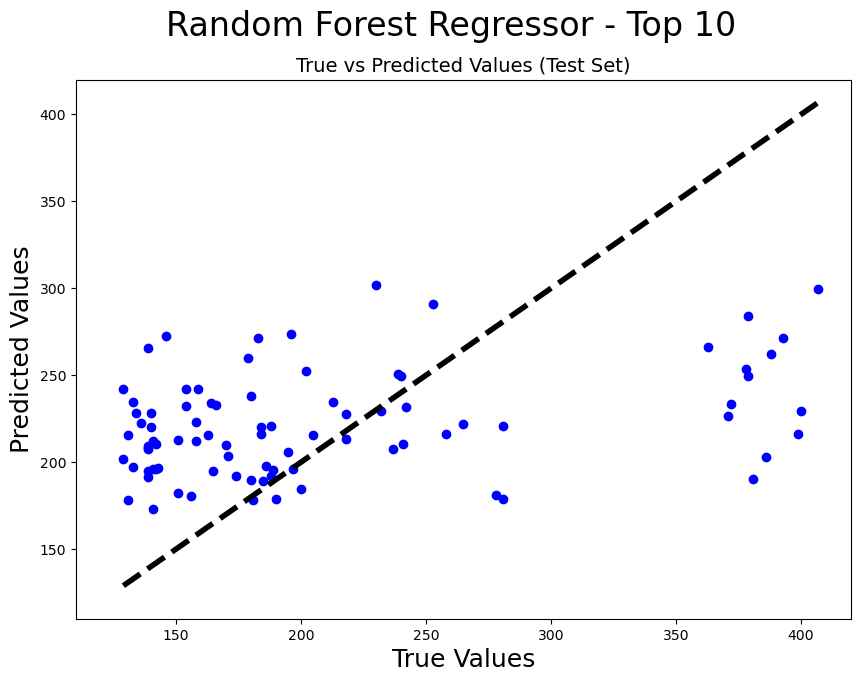

XGBoost Regressor - Top 10
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │    0.0214951 │
│ Average_Volume_USD          │    0.0327176 │
│ Average_DPM                 │    0.0366808 │
│ Unique_Symbols_Traded       │    0.0469768 │
│ Peak_Trading_Times          │    0.0270967 │
│ Profit_Loss_Variability     │    0.029654  │
│ Average_Trade_Duration      │    0.0506204 │
│ Average_Commission          │    0.117335  │
│ Average_Swaps               │    0.0608708 │
│ Average_Profit              │    0.0429881 │
│ average_net_deposit         │    0.0365437 │
│ Buy_Percentage              │    0.057397  │
│ TP/SL Hit Ratio             │    0.0602945 │
│ Reward_Risk_Ratio           │    0.0671423 │
│ Ratio_Profitable_Trades     │    0.0357227 │
│ net_deposit_frequency_ratio │    0.0642171 │
│ country                     │    0.0552919 │
│ 

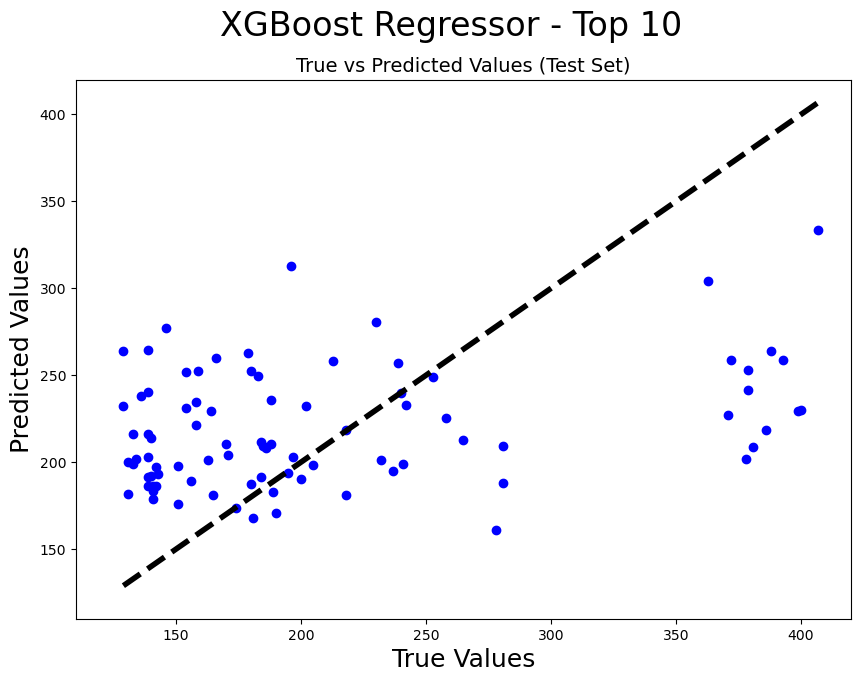

In [30]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name} - Top 10")
    # Train the model on the training set
    model.fit(X_train, y_train)

    DisplayFeatureImportanceOrCoefficients(model, X_preprocessed_df)

    # Evaluate Metrics on Model
    DisplayMetrics(model, X_val, y_val, "Validation")
    y_test_pred = DisplayMetrics(model, X_test, y_test, "Testing")

    PerformPlot(f"{name} - Top 10", y_test, y_test_pred, [110, 420])